# Deconvolve Simulated Linear Example

Indices:
- c cell type
- g genes
- m samples
- k deformation polynomial degree

In [1]:
import torch
from time_deconv.time_deconv_simulator import *
from time_deconv.time_deconv import *

## Parameter Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Train Model

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [7]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [8]:
pseudo_time_reg_deconv.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)

[iteration: 0]   loss: 30370669.54
[iteration: 1000]   loss: 8828506.86
[iteration: 2000]   loss: 3696003.78
[iteration: 3000]   loss: 2148004.16
[iteration: 4000]   loss: 1558377.70
[iteration: 5000]   loss: 1285225.56


## Examine Outputs

In [ ]:
pseudo_time_reg_deconv.plot_loss()

In [ ]:
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)

In [ ]:
pseudo_time_reg_deconv.plot_composition_trajectories()

In [ ]:
pseudo_time_reg_deconv.plot_phi_g_distribution()

In [ ]:
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Synthetic Data

In [ ]:
batch_dict = generate_batch(pseudo_time_reg_deconv.dataset, device, dtype)

## Evaluate Simulation 1 (100 samples; polynomial)

In [ ]:
# Simulate and plot proportions
sim_res = simulate_data(num_samples=100, reference_deconvolution=pseudo_time_reg_deconv, trajectory_type='linear')
plot_simulated_proportions(sim_res)
matplotlib.pyplot.show()

In [ ]:
simulated_bulk = generate_anndata_from_sim(sim_res, reference_deconvolution=pseudo_time_reg_deconv)

In [ ]:
ebov_simulated_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = simulated_bulk,
    bulk_time_col = "time",
    dtype_np = dtype_np,
    dtype = dtype,
    device = device,
    feature_selection_method = 'common' 
)

In [ ]:
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
    dataset=ebov_simulated_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [ ]:
pseudo_time_reg_deconv_sim.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)

In [ ]:
pseudo_time_reg_deconv_sim.plot_loss()

In [ ]:
pseudo_time_reg_deconv_sim.calculate_composition_trajectories(n_intervals = 1000)

In [ ]:
plot_simulated_proportions(sim_res)

In [ ]:
pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [ ]:
calculate_prediction_error(sim_res, pseudo_time_reg_deconv_sim)

## Evaluate linear fit error vs Increasing sampling noise

In [ ]:
alpha_vals = list(10**(x -1 ) for x in range(4)) 
alpha_vals

In [ ]:
# Use a single trajectory for all iterations
trajectory_coef = sample_linear_trajectories(num_cell_types = pseudo_time_reg_deconv.w_hat_gc.shape[1])

In [ ]:
df_a = []
l1_error = []

for a in alpha_vals:
    sim_res = simulate_data(
        num_samples=100, 
        reference_deconvolution=pseudo_time_reg_deconv, 
        trajectory_type='linear', 
        dirichlet_alpha = a,
        trajectory_coef = trajectory_coef
    )
    
    plot_simulated_proportions(sim_res)
    
    simulated_bulk = generate_anndata_from_sim(sim_res, reference_deconvolution=pseudo_time_reg_deconv)
    
    ebov_simulated_dataset = DeconvolutionDataset(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
        dtype_np = dtype_np,
        dtype = dtype,
        device = device,
        feature_selection_method = 'common' 
    )
    
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
        dataset=ebov_simulated_dataset,
        polynomial_degree = 3,
        basis_functions = "polynomial",
        device=device,
        dtype=dtype)
    
    pseudo_time_reg_deconv_sim.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)
    
    errors = calculate_prediction_error(sim_res, pseudo_time_reg_deconv_sim)
    df_a.append(a)
    l1_error.append(errors['L1_error_norm'])
    
    pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [ ]:
error_df = pd.DataFrame({'a':df_a, 'l1': list(x.item() for x in l1_error)})

In [ ]:
error_df.plot(x='a',y='l1')

## Periodic

In [ ]:
trajectory_type = 'periodic'

In [ ]:
alpha_vals = list(10**(x -1 ) for x in range(4)) 
alpha_vals

In [ ]:
# Use a single trajectory for all iterations
trajectory_coef = sample_trajectories(
    type = trajectory_type,
    num_cell_types = pseudo_time_reg_deconv.w_hat_gc.shape[1]
)

In [ ]:
df_a = []
l1_error = []

for a in alpha_vals:
    sim_res = simulate_data(
        num_samples=100, 
        reference_deconvolution=pseudo_time_reg_deconv, 
        trajectory_type=trajectory_type, 
        dirichlet_alpha = a,
        trajectory_coef = trajectory_coef
    )
    
    plot_simulated_proportions(sim_res)
    
    simulated_bulk = generate_anndata_from_sim(sim_res, reference_deconvolution=pseudo_time_reg_deconv)
    
    ebov_simulated_dataset = DeconvolutionDataset(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
        dtype_np = dtype_np,
        dtype = dtype,
        device = device,
        feature_selection_method = 'common' 
    )
    
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
        dataset=ebov_simulated_dataset,
        polynomial_degree = 3,
        basis_functions = "polynomial",
        device=device,
        dtype=dtype)
    
    pseudo_time_reg_deconv_sim.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)
    
    errors = calculate_prediction_error(sim_res, pseudo_time_reg_deconv_sim)
    df_a.append(a)
    l1_error.append(errors['L1_error_norm'])
    
    pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [ ]:
error_df = pd.DataFrame({'a':df_a, 'l1': list(x.item() for x in l1_error)})

In [ ]:
error_df.plot(x='a',y='l1')

## Periodic with high degree polynomial

In [9]:
trajectory_type = 'periodic'

In [10]:
alpha_vals = list(10**(x -1 ) for x in range(4)) 
alpha_vals

[0.1, 1, 10, 100]

In [11]:
# Use a single trajectory for all iterations
trajectory_coef = sample_trajectories(
    type = trajectory_type,
    num_cell_types = pseudo_time_reg_deconv.w_hat_gc.shape[1]
)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[iteration: 0]   loss: 2424127.39
[iteration: 1000]   loss: 1912952.95
[iteration: 2000]   loss: 1689796.12
[iteration: 3000]   loss: 1597111.87


UnboundLocalError: local variable 'predicted_composition_norm_cm' referenced before assignment

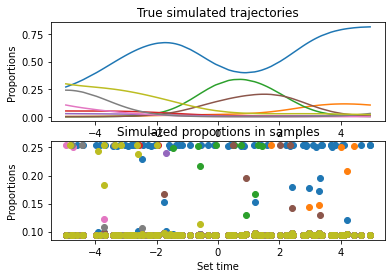

In [12]:
df_a = []
l1_error = []

for a in alpha_vals:
    sim_res = simulate_data(
        num_samples=100, 
        reference_deconvolution=pseudo_time_reg_deconv, 
        trajectory_type=trajectory_type, 
        dirichlet_alpha = a,
        trajectory_coef = trajectory_coef
    )
    
    plot_simulated_proportions(sim_res)
    
    simulated_bulk = generate_anndata_from_sim(sim_res, reference_deconvolution=pseudo_time_reg_deconv)
    
    ebov_simulated_dataset = DeconvolutionDataset(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
        dtype_np = dtype_np,
        dtype = dtype,
        device = device,
        feature_selection_method = 'common' 
    )
    
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
        dataset=ebov_simulated_dataset,
        polynomial_degree = 10,
        basis_functions = "polynomial",
        device=device,
        dtype=dtype)
    
    pseudo_time_reg_deconv_sim.fit_model(n_iters=3_001, verbose=True, log_frequency=1000)
    
    errors = calculate_prediction_error(sim_res, pseudo_time_reg_deconv_sim)
    df_a.append(a)
    l1_error.append(errors['L1_error_norm'])
    
    pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [ ]:
error_df = pd.DataFrame({'a':df_a, 'l1': list(x.item() for x in l1_error)})
error_df.plot(x='a',y='l1')

### Same trajectory Vary the number of samples

In [ ]:
trajectory_type = 'periodic'

In [ ]:
n_samples = list(range(10,100,10)) 
n_samples

In [ ]:
# Use a single trajectory for all iterations
trajectory_coef = sample_trajectories(
    type = trajectory_type,
    num_cell_types = pseudo_time_reg_deconv.w_hat_gc.shape[1]
)

In [ ]:
df_n = []
l1_error = []
shape_l1_error = []

a = 10

for n in n_samples:
    
    sim_res = simulate_data(
        num_samples=n, 
        reference_deconvolution=pseudo_time_reg_deconv, 
        trajectory_type=trajectory_type, 
        dirichlet_alpha = a,
        trajectory_coef = trajectory_coef
    )
    
    plot_simulated_proportions(sim_res)
    
    simulated_bulk = generate_anndata_from_sim(
        sim_res, 
        reference_deconvolution=pseudo_time_reg_deconv)
    
    ebov_simulated_dataset = DeconvolutionDataset(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
        dtype_np = dtype_np,
        dtype = dtype,
        device = device,
        feature_selection_method = 'common' 
    )
    
    pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
        dataset=ebov_simulated_dataset,
        polynomial_degree = 10,
        basis_functions = "polynomial",
        device=device,
        dtype=dtype)
    
    pseudo_time_reg_deconv_sim.fit_model(n_iters=3_001, verbose=True, log_frequency=1000)
    
    errors = calculate_prediction_error(sim_res, pseudo_time_reg_deconv_sim)
    
    df_n.append(n)
    l1_error.append(errors['L1_error_norm'])
    shape_l1_error.append(errors['shape_L1_error'])
    
    pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [ ]:
pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()

In [ ]:
pyro.param("unnorm_cell_pop_deform_posterior_loc_ck").detach().cpu()

In [ ]:
error_df = pd.DataFrame({'n':df_n, 'l1': list(x.item() for x in l1_error)})
error_df.plot(x='n',y='l1')